In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
from ensemble.generate import generate
import starry
from starry_process import StarryProcess
import theano
import theano.tensor as tt
import os
from tqdm.notebook import tqdm

In [32]:
runid = 1
PATH = "ensemble"
DATA_FILE = os.path.join(PATH, "{:02d}".format(runid), "data.npz")
TRUTH_FILE = os.path.join(PATH, "{:02d}".format(runid), "truth.npz")
data, truth = generate(runid)
t = data["t"]
flux = data["flux"]
ferr = data["ferr"]
nlc = len(flux)
baseline_var = 1e-2

Pre-computing some matrices... Done.
  0%|          | 0/10 [00:00<?, ?it/s]Compiling `flux`... Done.
Compiling `render`... Done.
100%|██████████| 10/10 [00:00<00:00, 4928.68it/s]


In [33]:
def _lnlike(size, la, lb, c, N, incs):
    sp = StarryProcess(size=size, latitude=[la, lb], contrast=[c, N])
    log_like = []
    for k in range(nlc):
        log_like.append(
            sp.log_likelihood(
                t,
                flux[k],
                ferr ** 2,
                baseline_var=baseline_var,
                period=truth["periods"][k],
                inc=incs[k],
            )
        )
    return (
        tt.sum(log_like)
        + tt.sum(tt.log(tt.sin(incs * np.pi / 180)))
        + sp.log_jac()
    )

size = tt.dscalar()
la = tt.dscalar()
lb = tt.dscalar()
c = tt.dscalar()
N = tt.dscalar()
incs = tt.dvector()
lnlike = theano.function(
    [size, la, lb, c, N, incs], _lnlike(size, la, lb, c, N, incs)
)

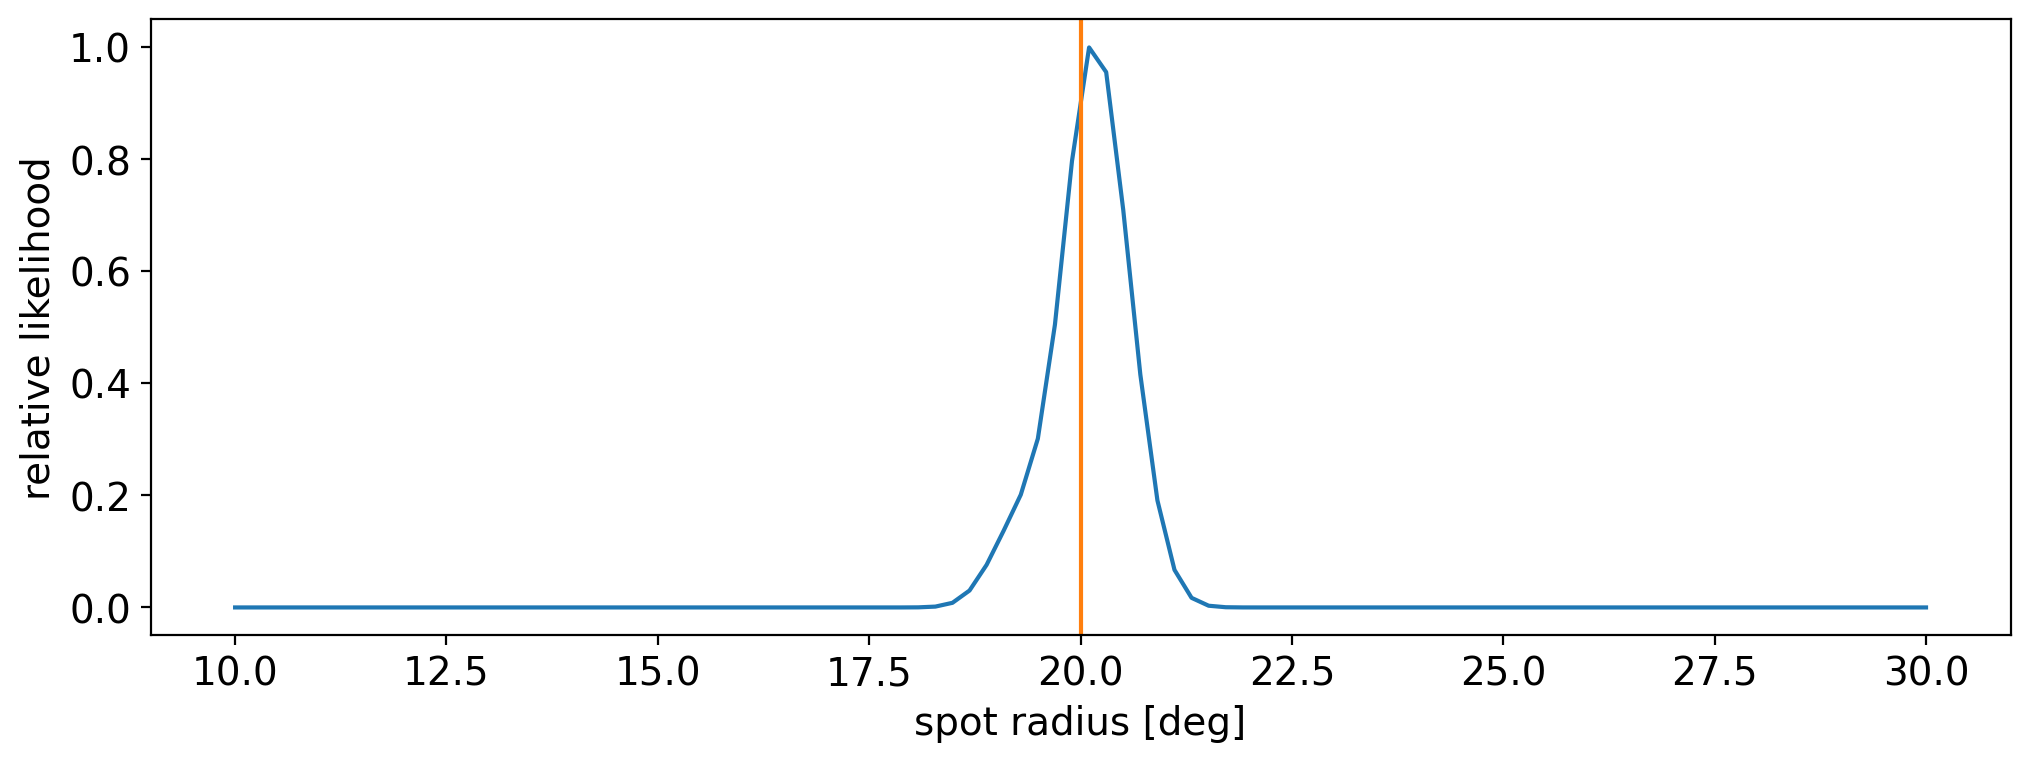

In [34]:
size = np.linspace(10, 30, 100)
ll = np.zeros_like(size)
for i in tqdm(range(len(size))):
    ll[i] = lnlike(
        size[i],
        truth["la"],
        truth["lb"],
        truth["c"],
        truth["N"],
        truth["incs"],
    )
plt.plot(size, np.exp(ll - ll.max()))
plt.axvline(truth["s"], color="C1")
plt.xlabel("spot radius [deg]")
plt.ylabel("relative likelihood");

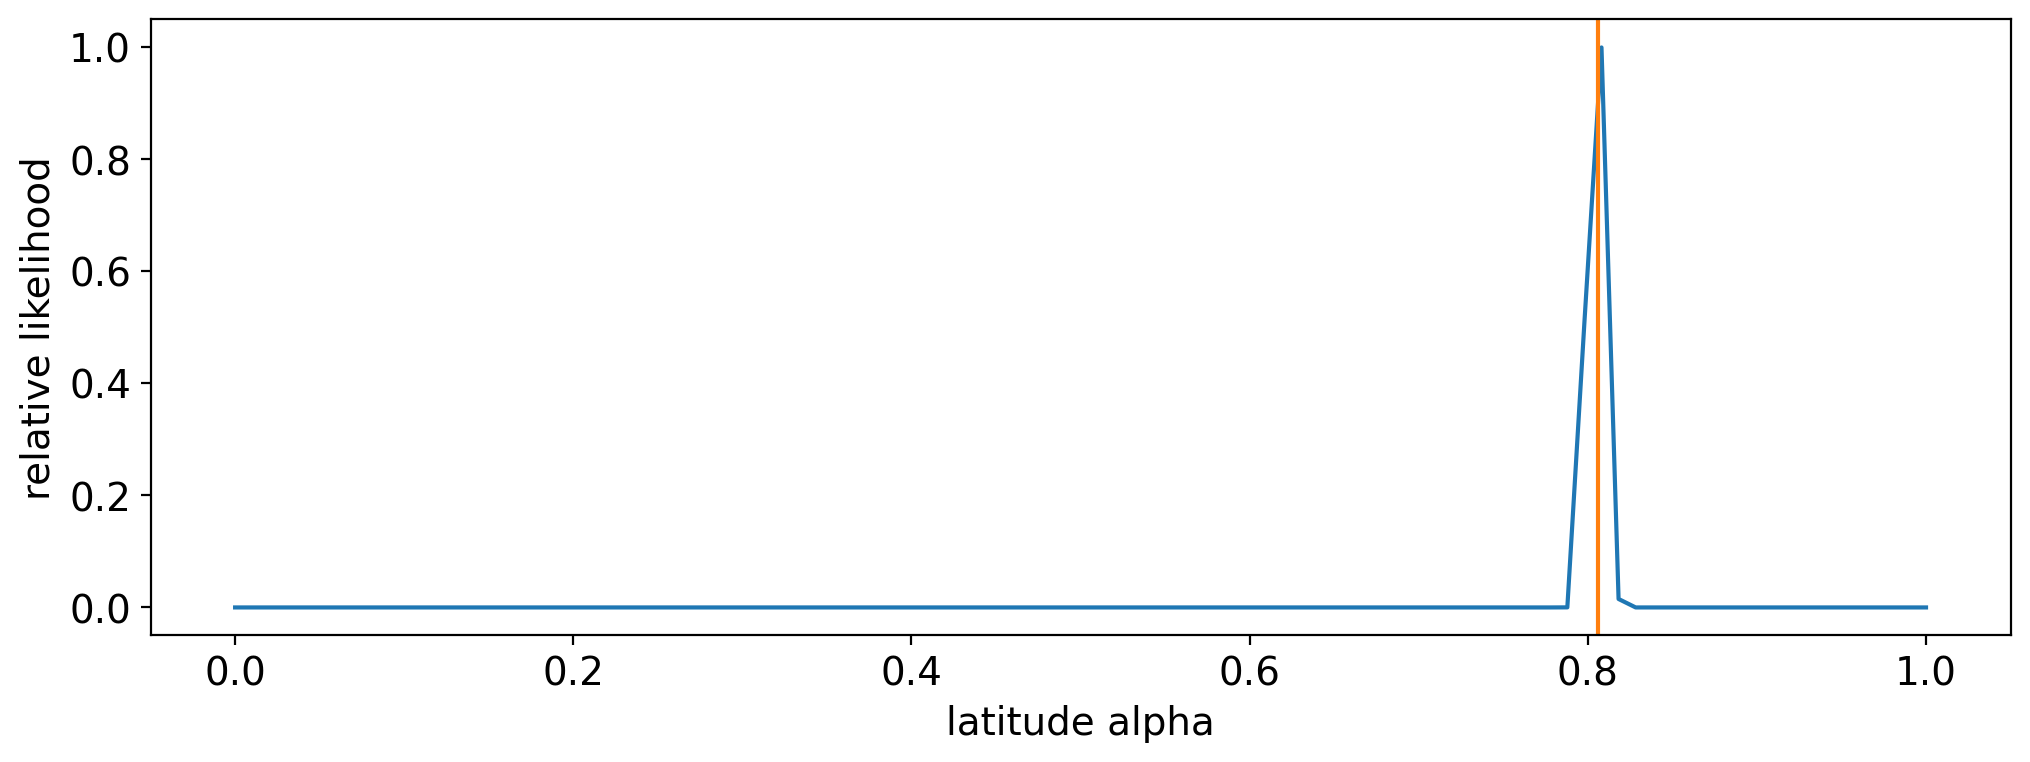

In [35]:
la = np.linspace(0, 1, 100)
ll = np.zeros_like(la)
for i in tqdm(range(len(la))):
    ll[i] = lnlike(
        truth["s"],
        la[i],
        truth["lb"],
        truth["c"],
        truth["N"],
        truth["incs"],
    )
plt.plot(la, np.exp(ll - ll.max()))
plt.axvline(truth["la"], color="C1")
plt.xlabel("latitude alpha")
plt.ylabel("relative likelihood");

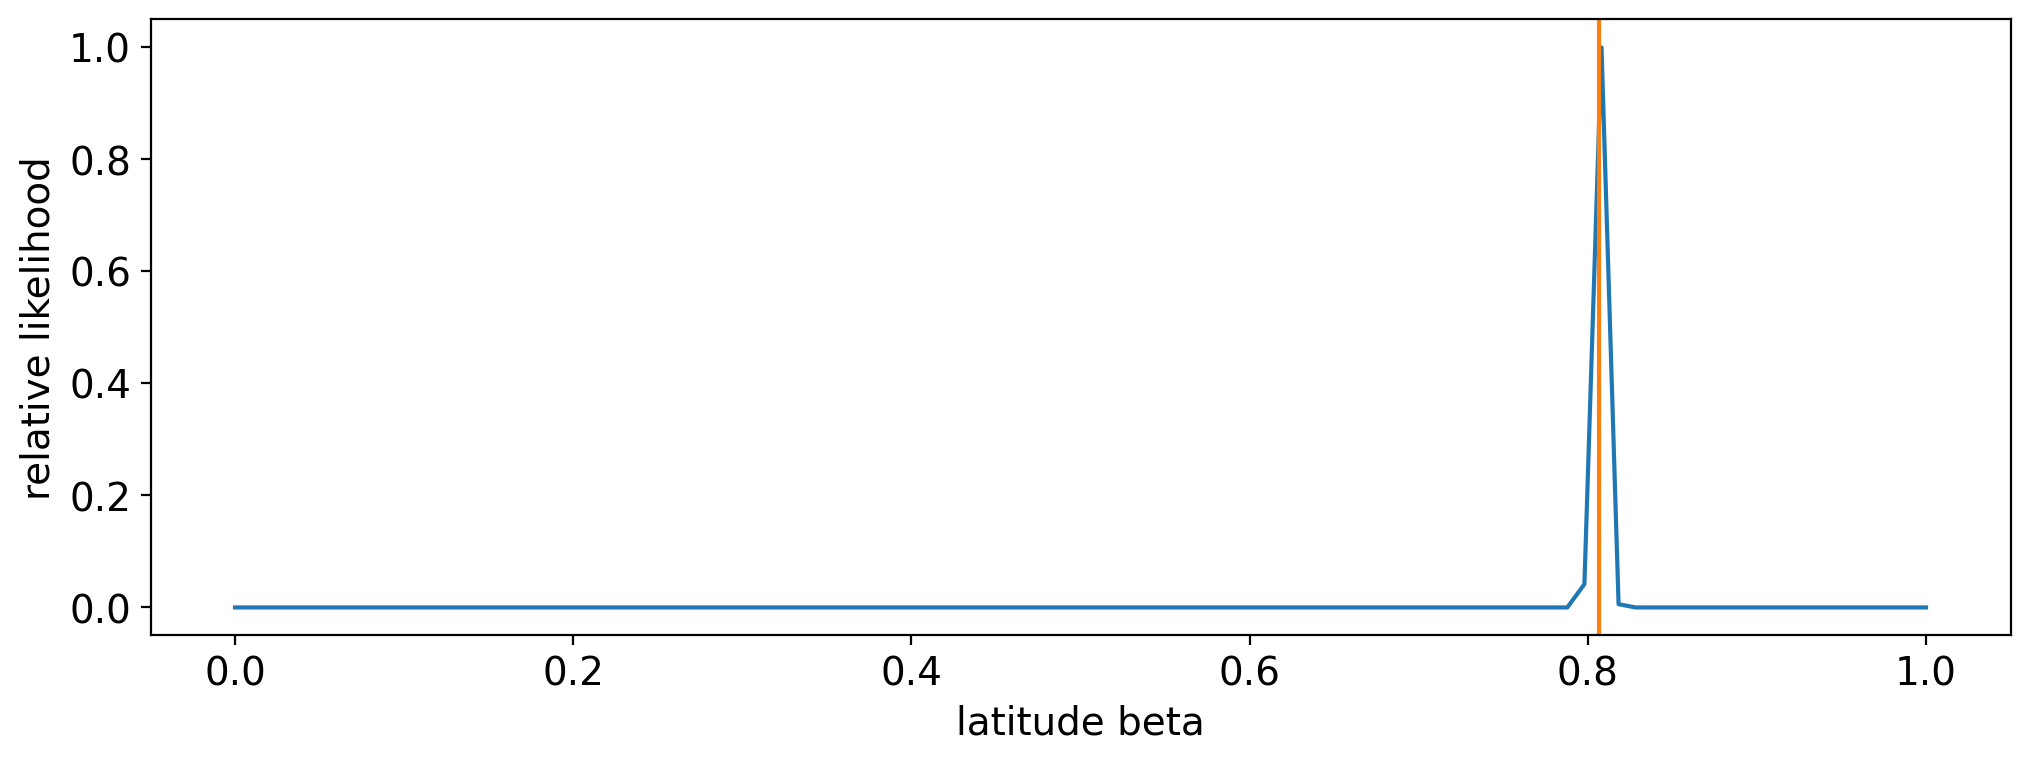

In [36]:
lb = np.linspace(0, 1, 100)
ll = np.zeros_like(lb)
for i in tqdm(range(len(lb))):
    ll[i] = lnlike(
        truth["s"],
        truth["la"],
        lb[i],
        truth["c"],
        truth["N"],
        truth["incs"],
    )
plt.plot(lb, np.exp(ll - ll.max()))
plt.axvline(truth["lb"], color="C1")
plt.xlabel("latitude beta")
plt.ylabel("relative likelihood");

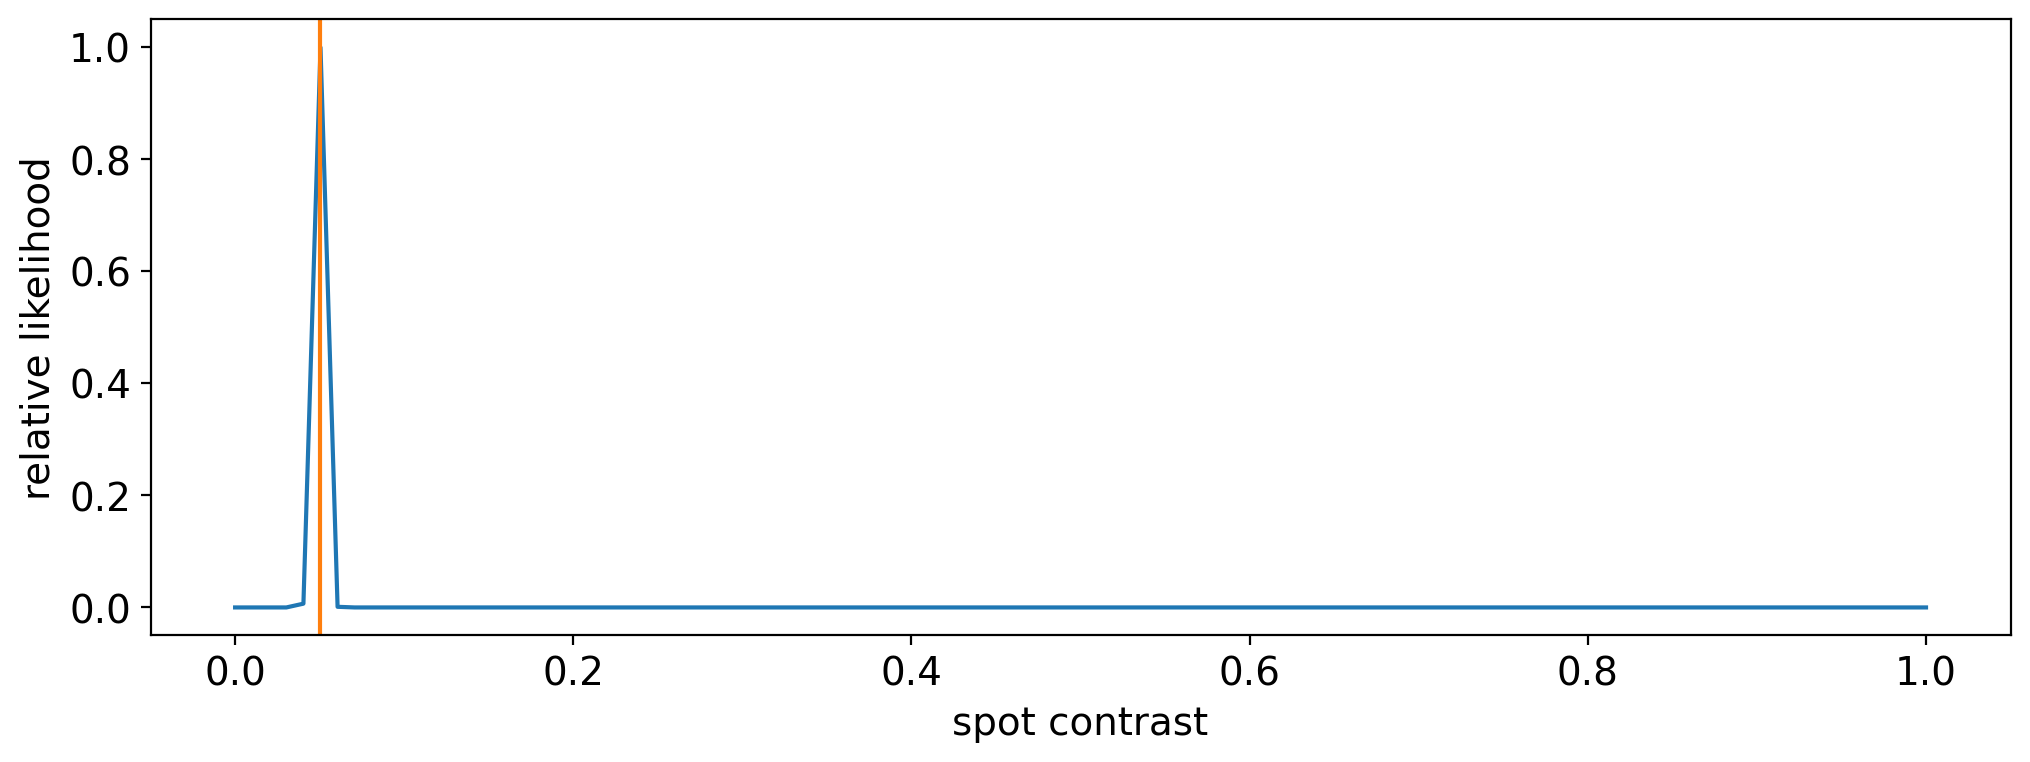

In [37]:
c = np.linspace(0, 1, 100)
ll = np.zeros_like(c)
for i in tqdm(range(len(c))):
    ll[i] = lnlike(
        truth["s"],
        truth["la"],
        truth["lb"],
        c[i],
        truth["N"],
        truth["incs"],
    )
plt.plot(c, np.exp(ll - ll.max()))
plt.axvline(truth["c"], color="C1")
plt.xlabel("spot contrast")
plt.ylabel("relative likelihood");

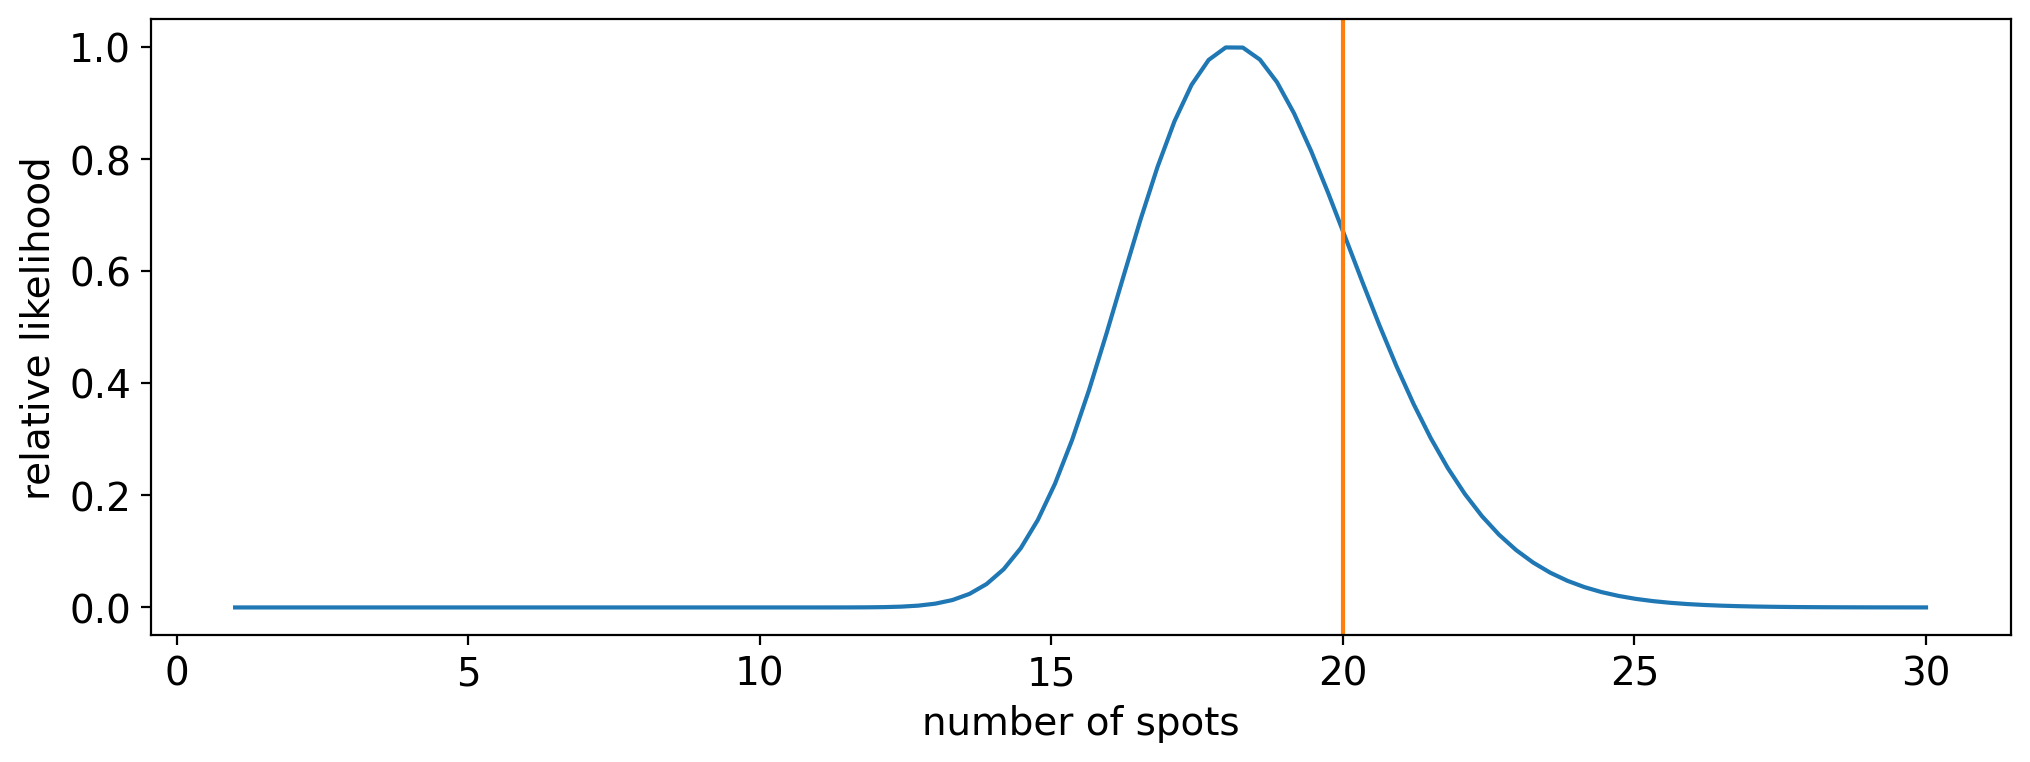

In [38]:
N = np.linspace(1, 30, 100)
ll = np.zeros_like(N)
for i in tqdm(range(len(N))):
    ll[i] = lnlike(
        truth["s"],
        truth["la"],
        truth["lb"],
        truth["c"],
        N[i],
        truth["incs"],
    )
plt.plot(N, np.exp(ll - ll.max()))
plt.axvline(truth["N"], color="C1")
plt.xlabel("number of spots")
plt.ylabel("relative likelihood");

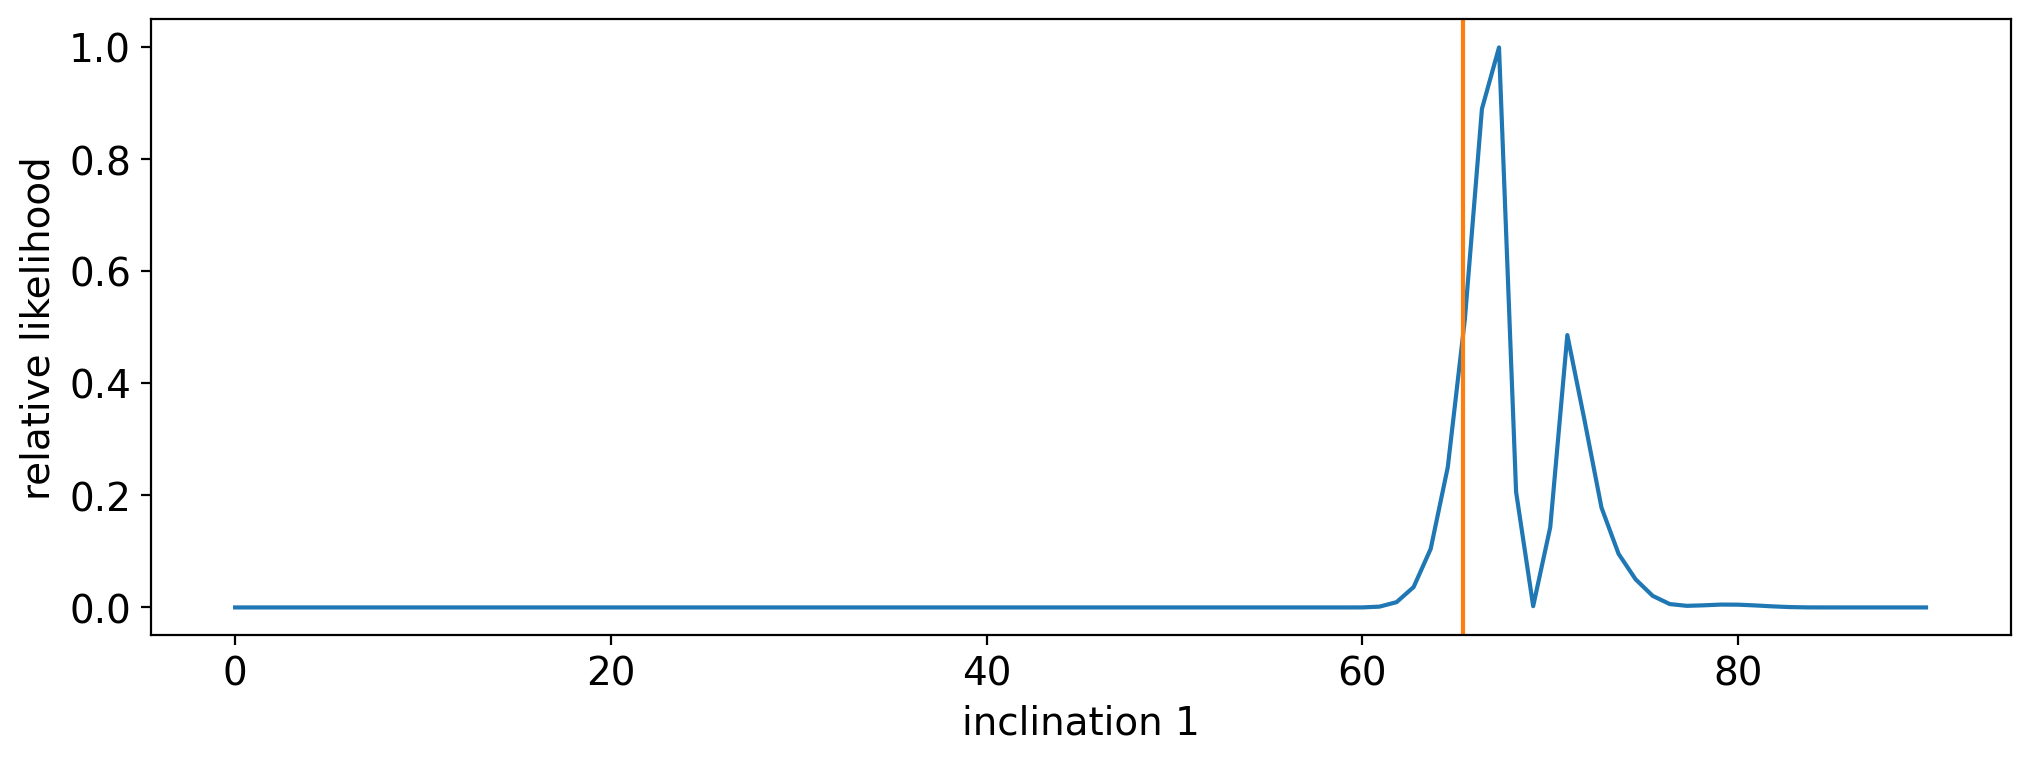

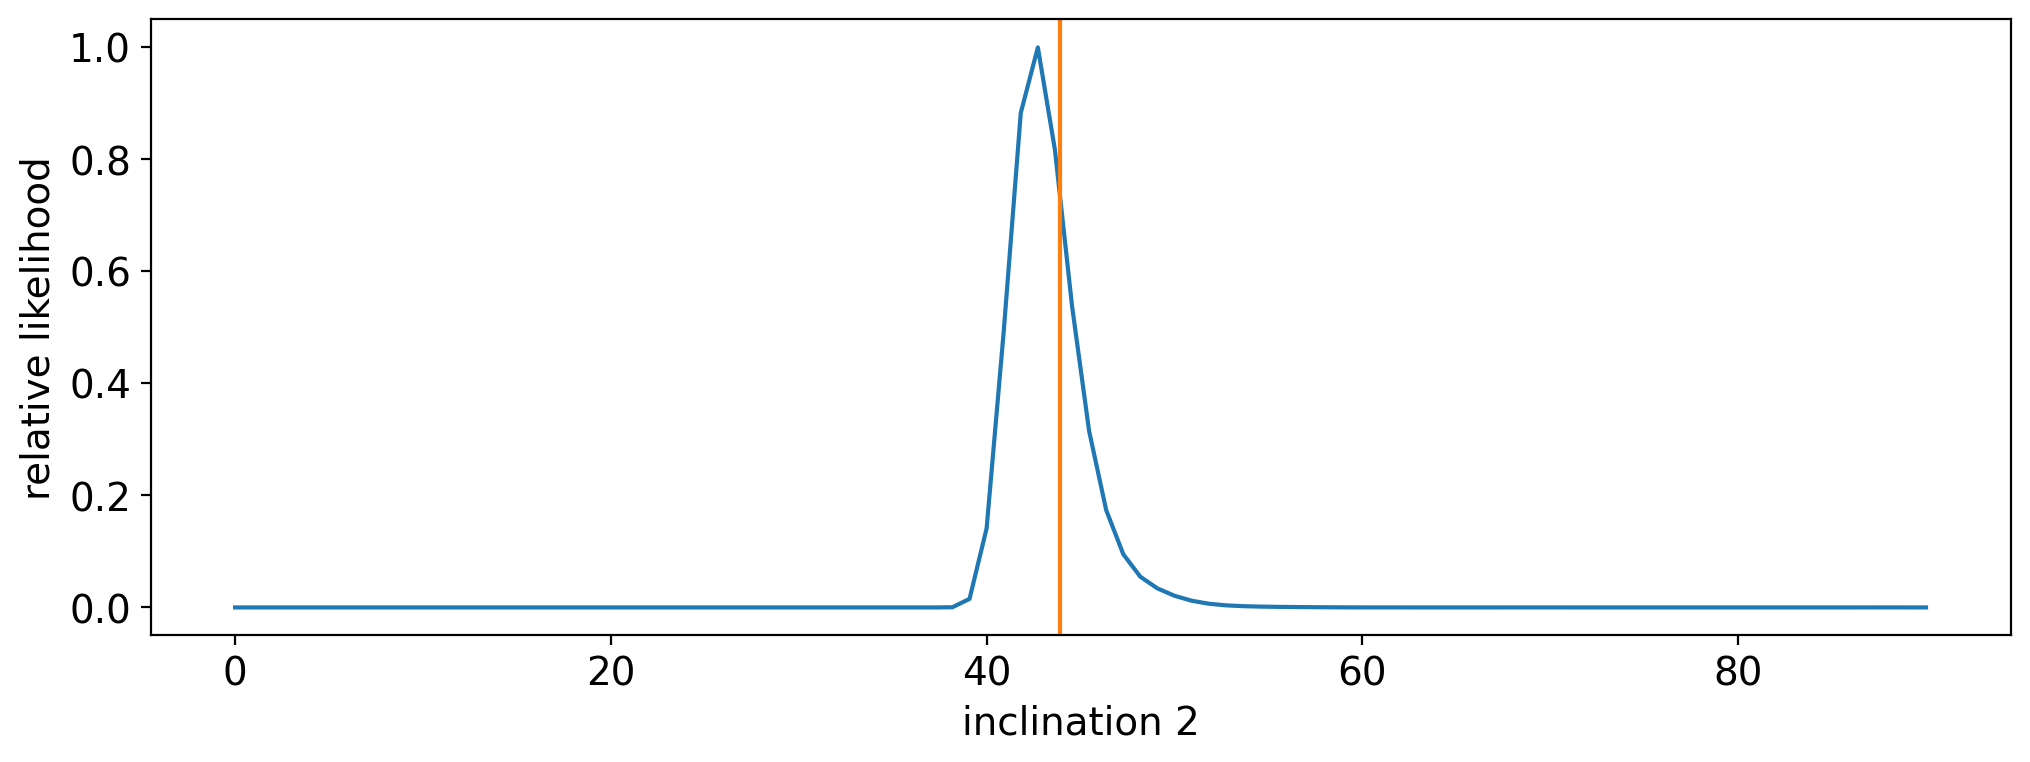

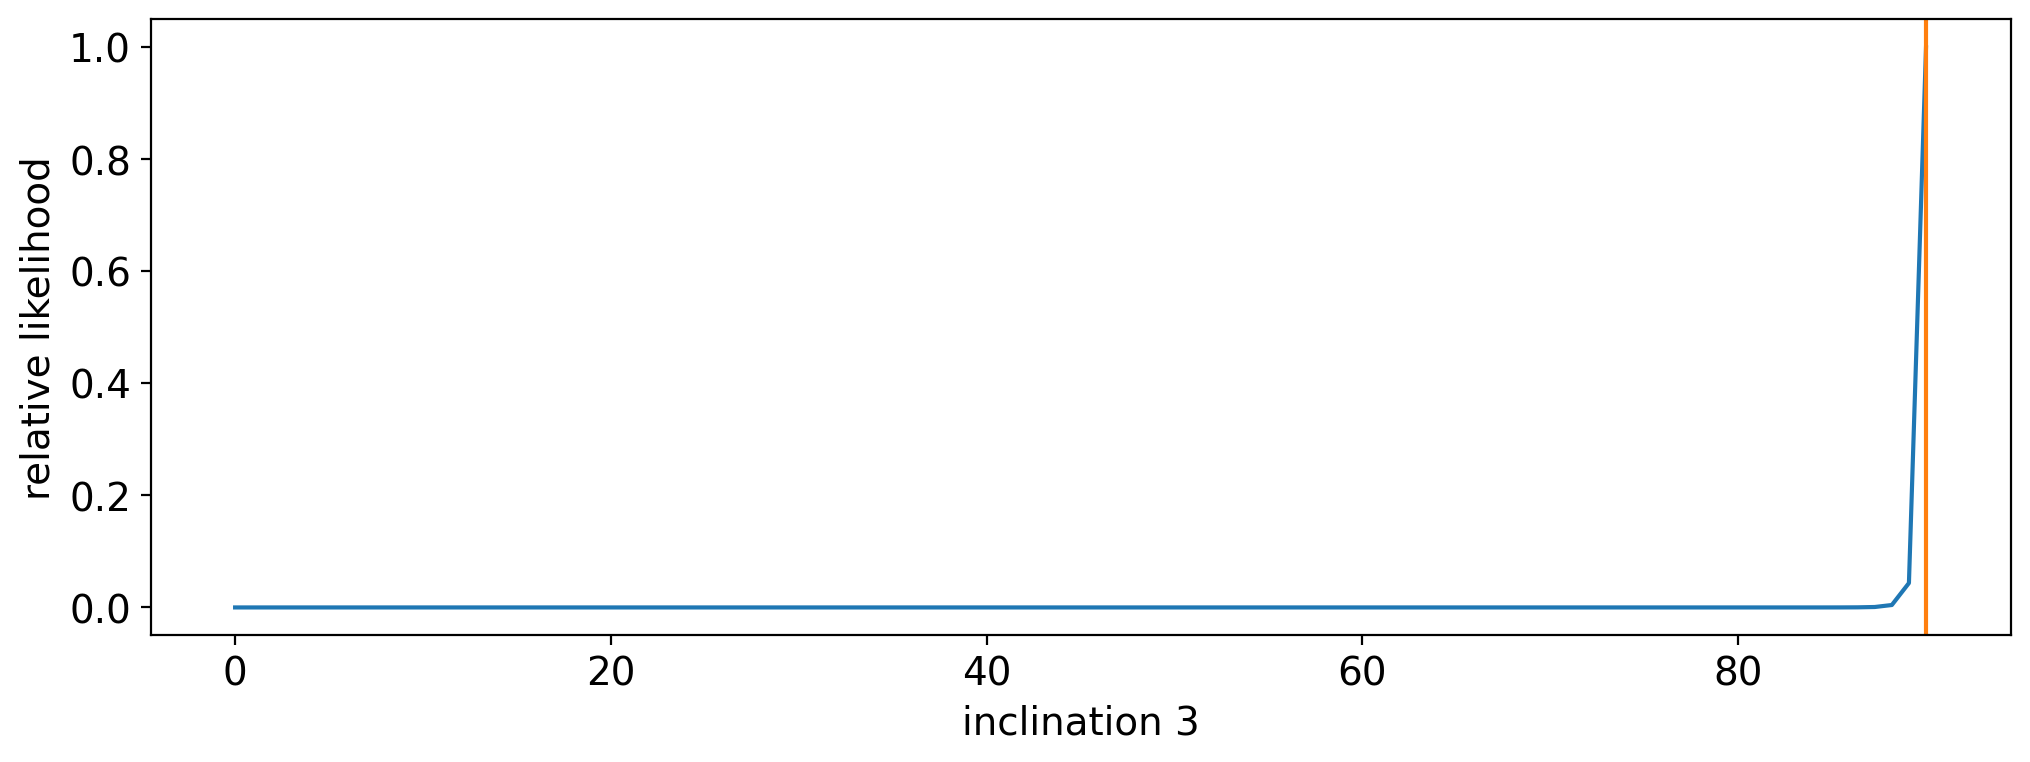

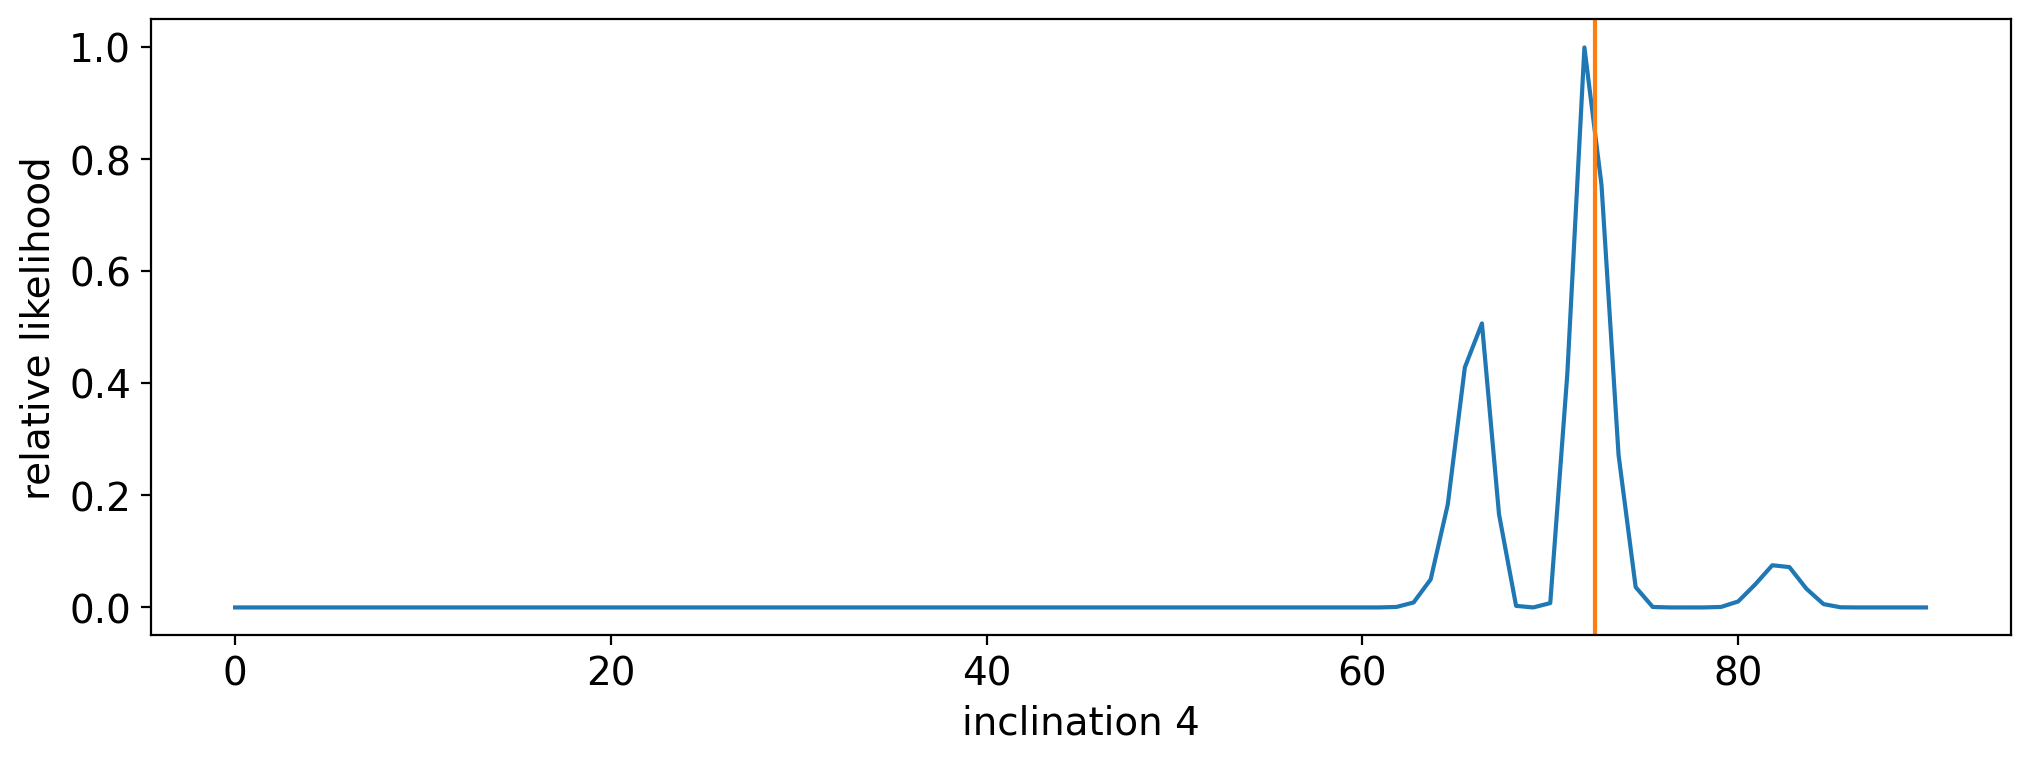

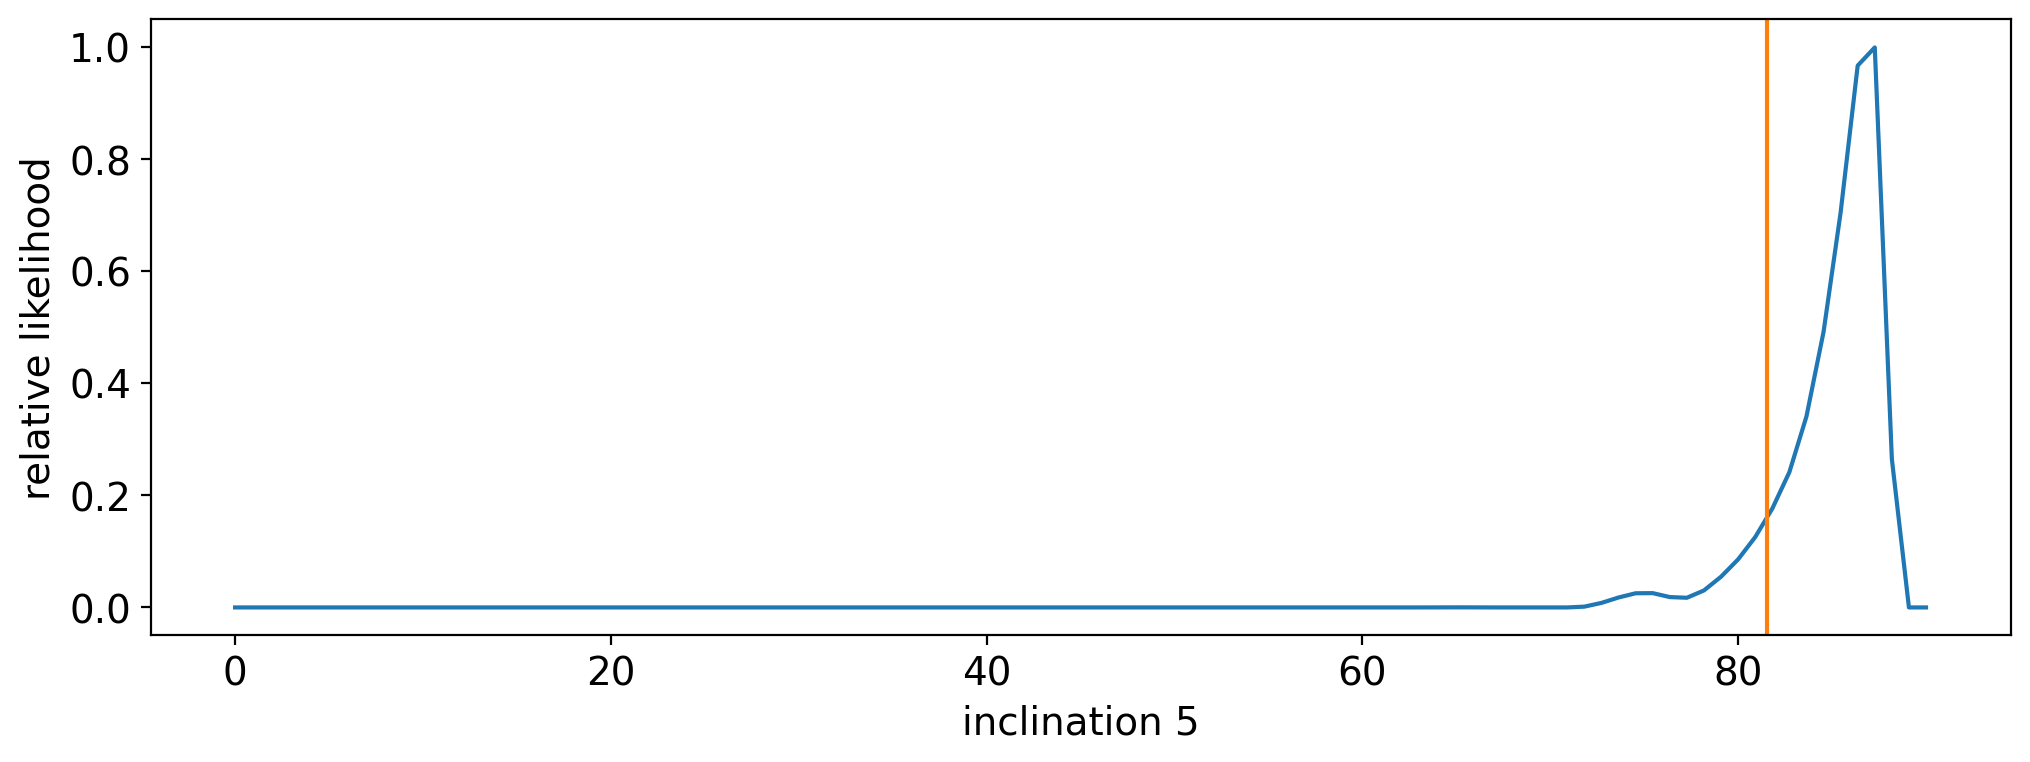

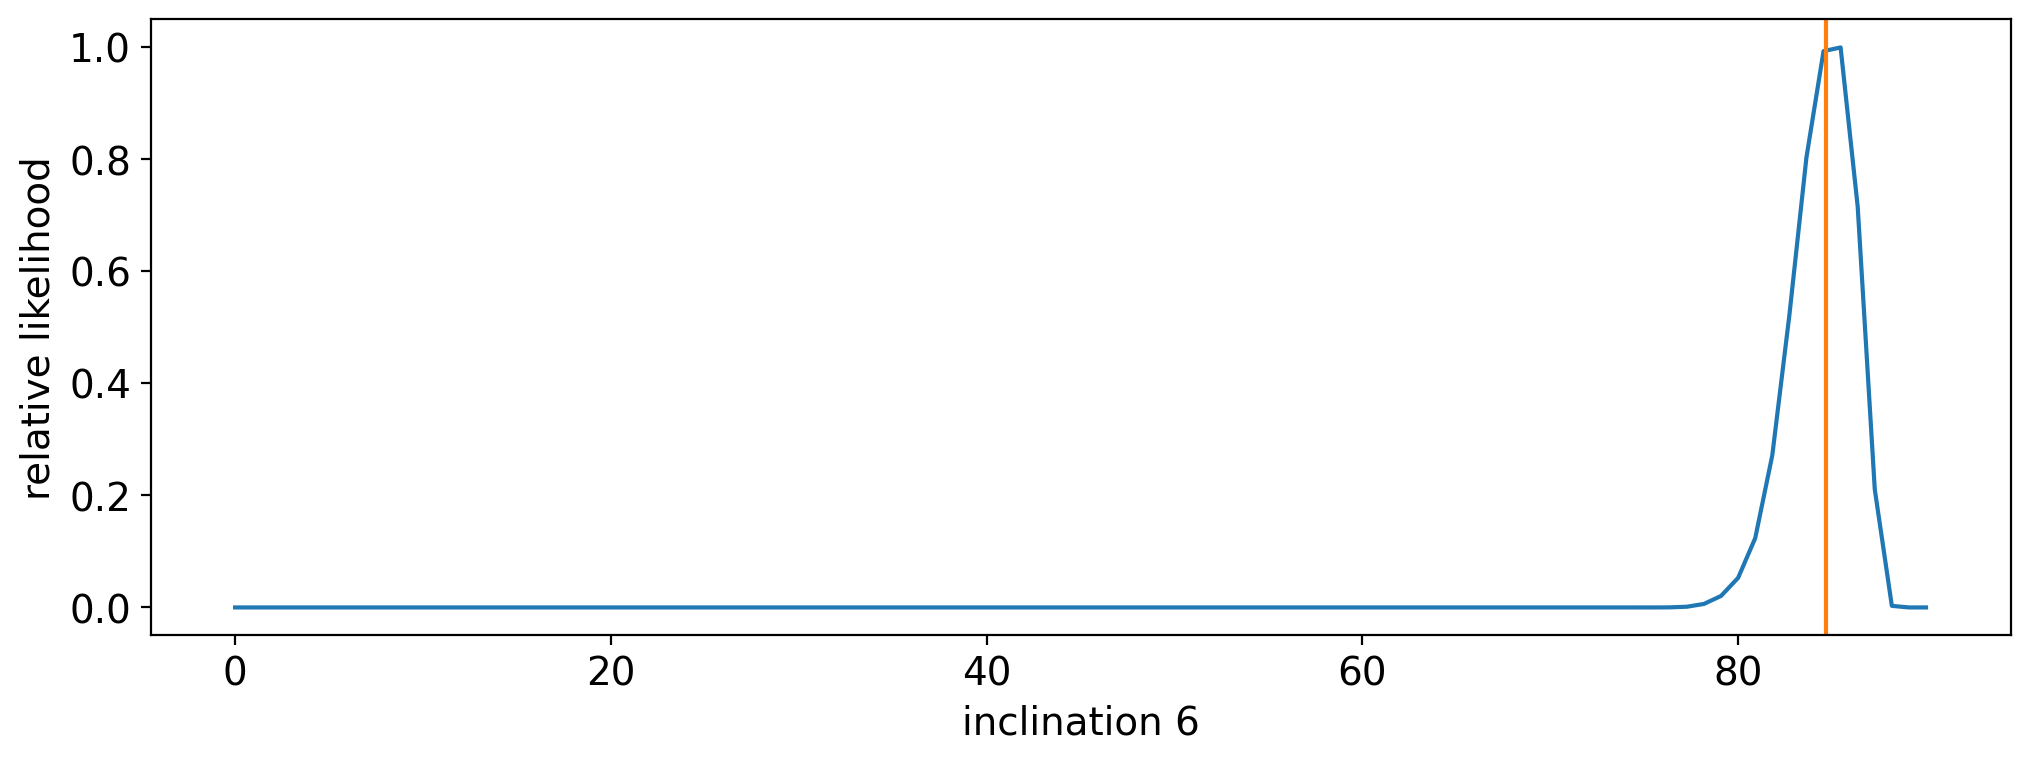

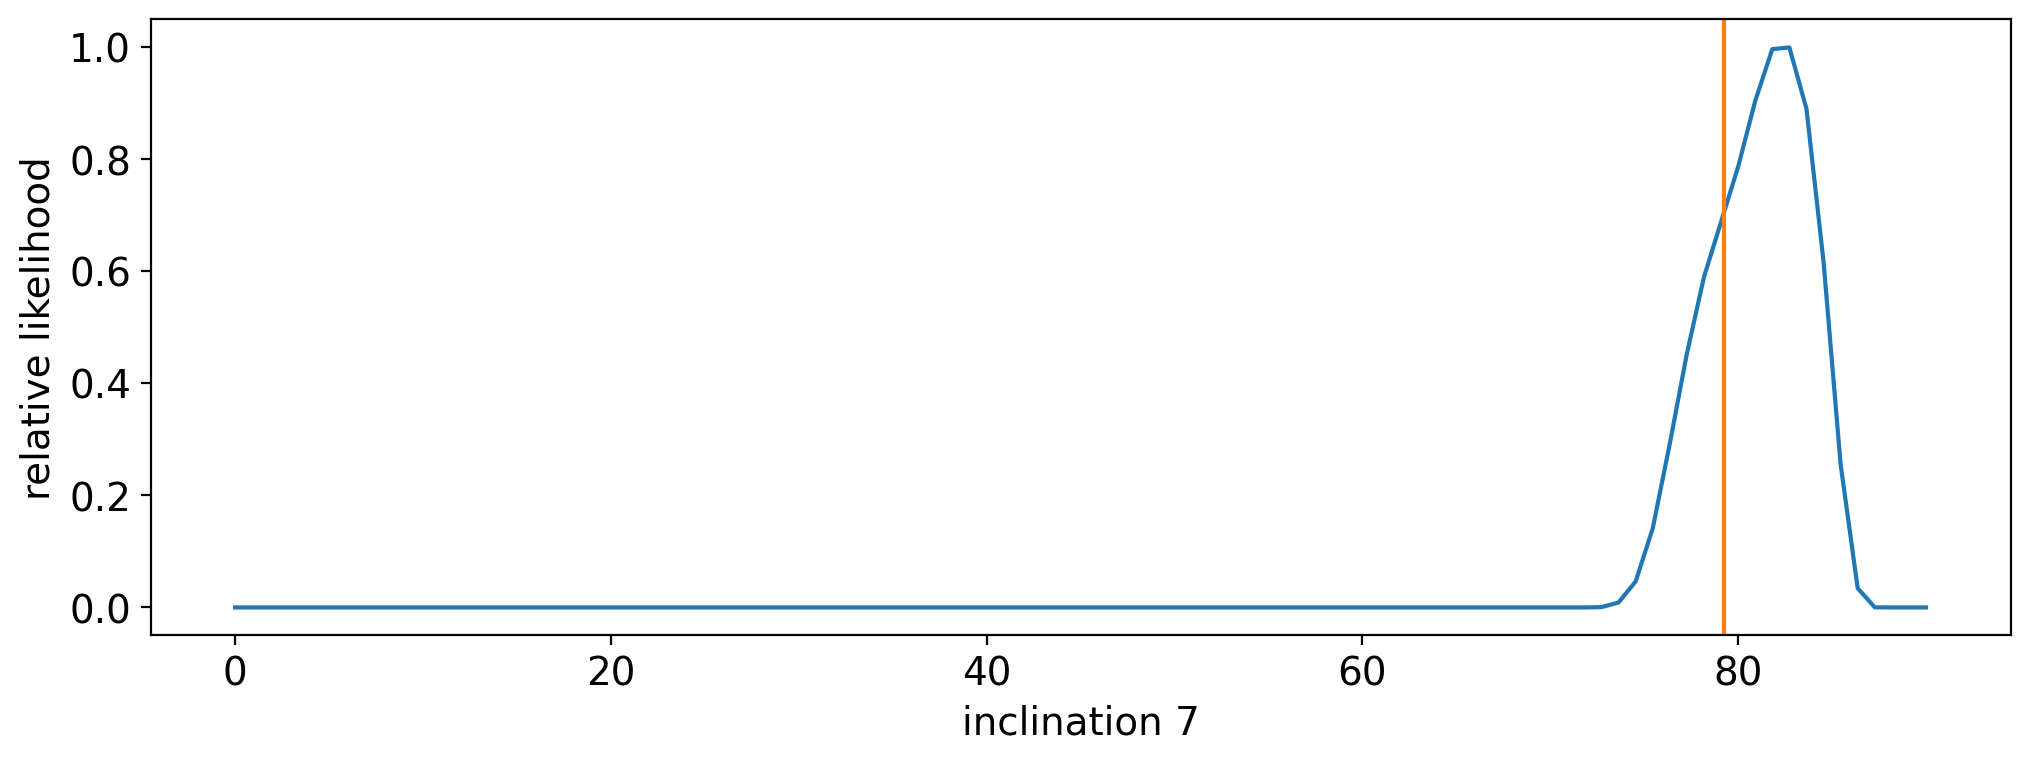

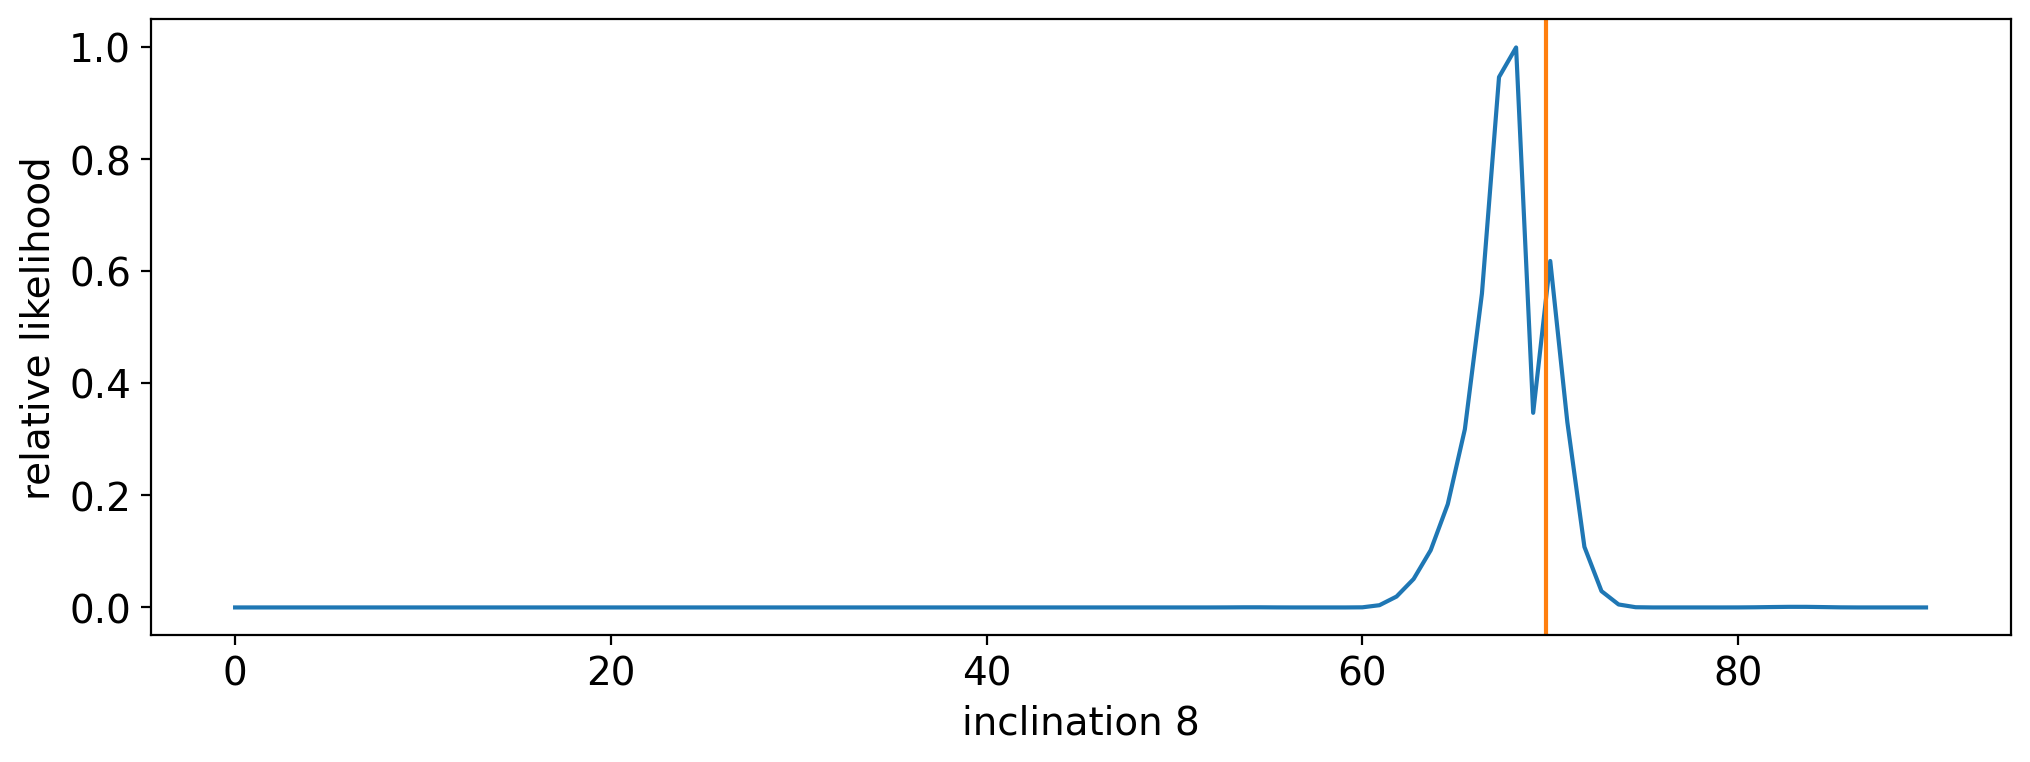

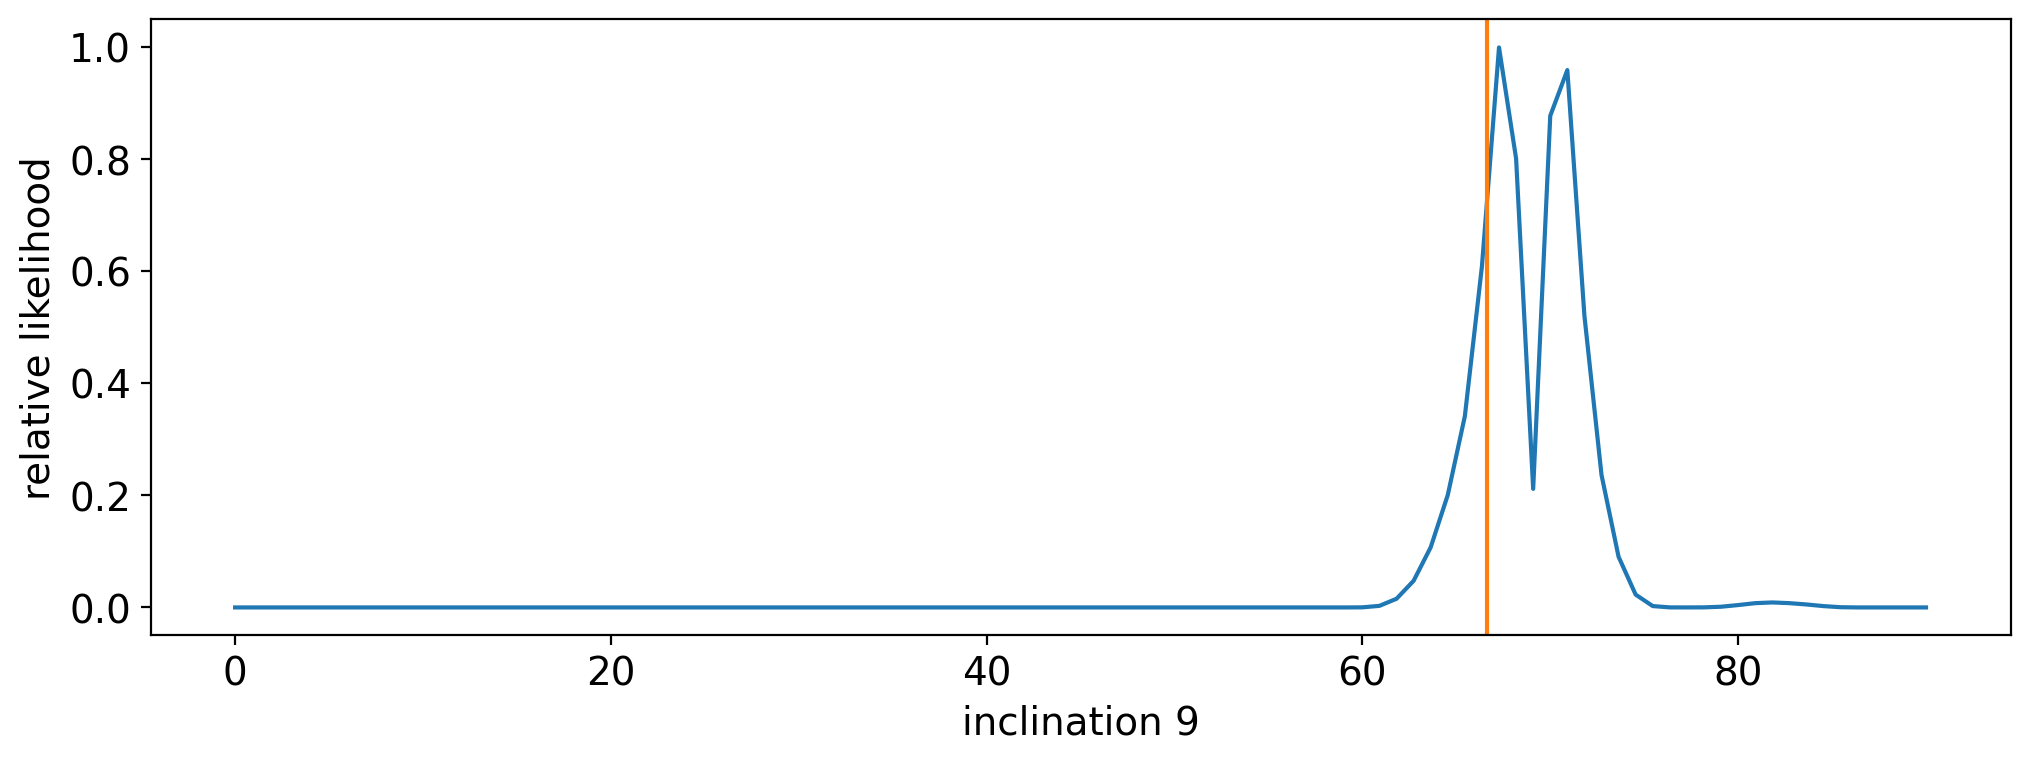

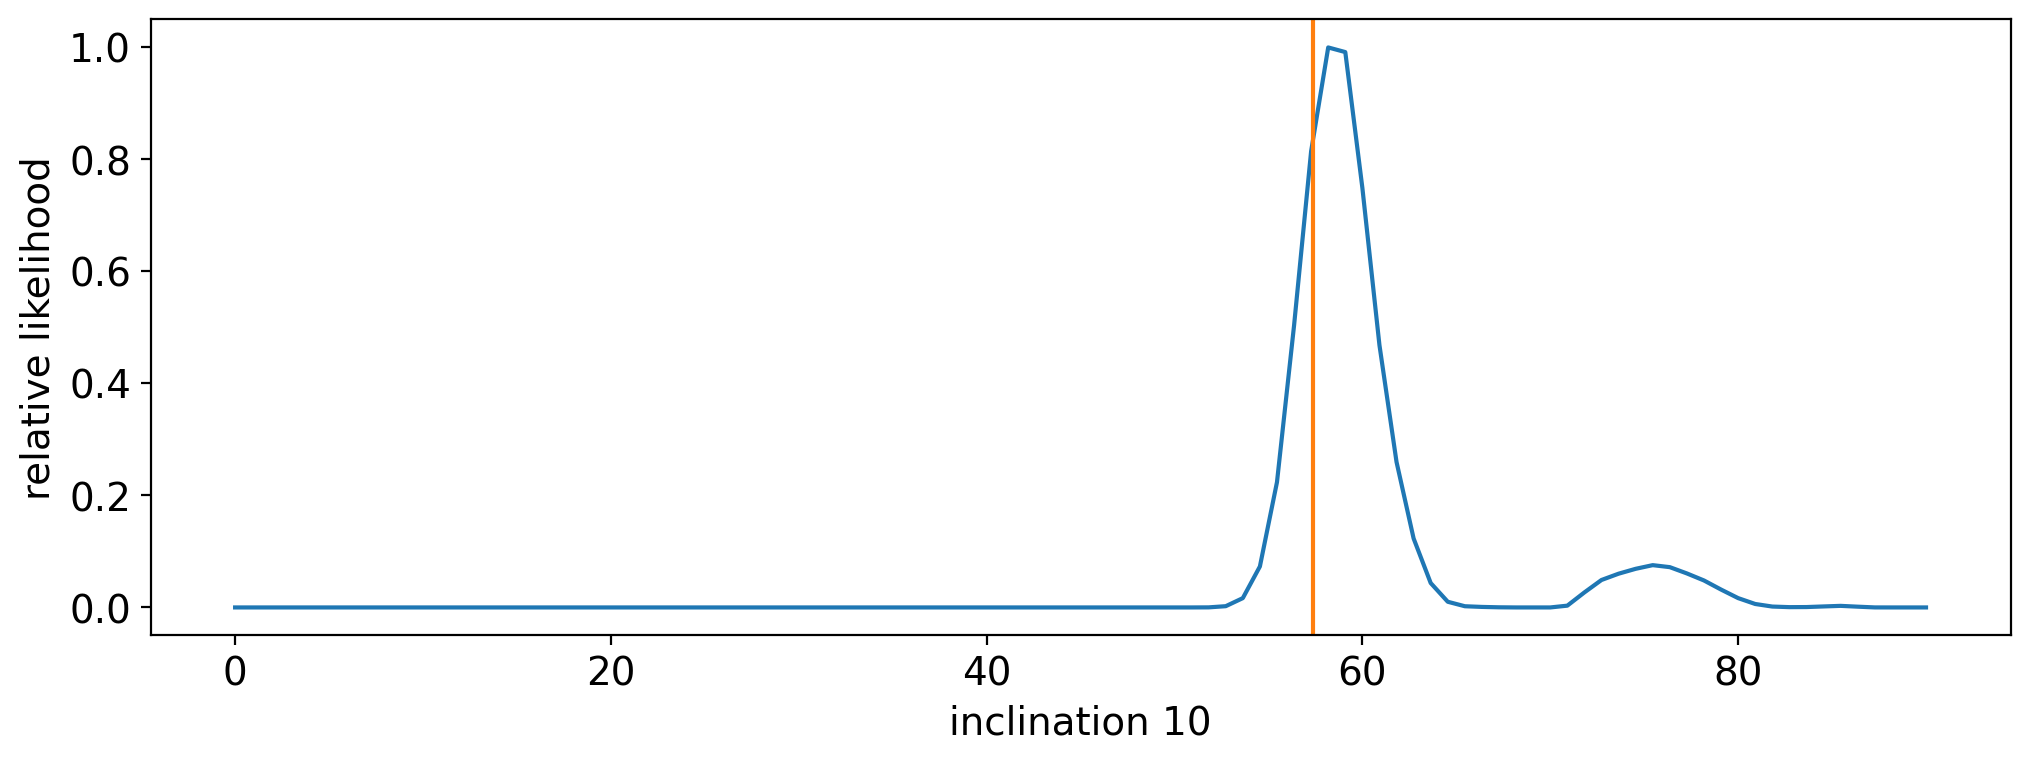

In [39]:
for k in range(nlc):
    inc = np.linspace(0, 90, 100)
    ll = np.zeros_like(N)
    for i in tqdm(range(len(N))):
        incs = np.array(truth["incs"])
        incs[k] = inc[i]
        ll[i] = lnlike(
            truth["s"],
            truth["la"],
            truth["lb"],
            truth["c"],
            truth["N"],
            incs,
        )
    plt.figure()
    plt.plot(inc, np.exp(ll - ll.max()))
    plt.axvline(truth["incs"][k], color="C1")
    plt.xlabel("inclination {}".format(k + 1))
    plt.ylabel("relative likelihood");